In [1]:
import os
os.getcwd()
os.chdir("G:/OneDrive/casa0010dissertation/00_06 jaipur code_mgwr")

In [2]:
import geopandas as gpd
import pandas as pd
import pathlib

In [3]:
ROOT = pathlib.Path("data")

# Paths relative to ROOT
HEX  = ROOT / "raw"     / "pca" / "jaipur_hex500_core_0.5.geojson"
OUT  = ROOT / "cleaned" / "pca" / "jaipur_hex_vectors.gpkg"

In [4]:
# A simple registry for the six vector layers
layers = {
    "transport_station_point":  {"type": "point",   "file": ROOT / "raw"     / "pca" / "transport_stations_points_jaipur.geojson"},
    "transport_station_polygon":{"type": "polygon", "file": ROOT / "raw"     / "pca" /  "transport_stations_polygons_jaipur.geojson"},
    "motorable_road_nexwork":   {"type": "line",    "file": ROOT / "raw"     / "pca" /  "road_network_jaipur.geojson"},
    "amenities_poi":            {"type": "point",   "file": ROOT / "raw"     / "pca" /  "amenities_jaipur.geojson"},
    "office_poi":               {"type": "point",   "file": ROOT / "raw"     / "pca" /  "offices_jaipur.geojson"},
    "shop_poi":                 {"type": "point",   "file": ROOT / "raw"     / "pca" /  "shops_jaipur.geojson"},
}

# 1 Aggregate vector data

In [5]:
# 1) Load hex grid
hexes = gpd.read_file(HEX).to_crs(32643)

# 'id' is object → cast to signed 32-bit integer and rename to hex_id
hexes = hexes.rename(columns={"id": "hex_id"})
hexes["hex_id"] = pd.to_numeric(hexes["hex_id"], errors="raise").astype("int32")

In [6]:
hexes.head()

,hex_id,left,top,right,bottom,row_index,col_index,area_cell,area_clip,cover,geometry
0,23,568325.7194,2978580.082,568903.069669,2978080.082,22,0,216506.350946,200463.974238,0.925903,"POLYGON ((568325.719 2978330.082, 568470.057 2..."
1,24,568325.7194,2978080.082,568903.069669,2977580.082,23,0,216506.350946,214735.897760,0.991823,"POLYGON ((568325.719 2977830.082, 568470.057 2..."
2,25,568325.7194,2977580.082,568903.069669,2977080.082,24,0,216506.350946,216196.262539,0.998568,"POLYGON ((568325.719 2977330.082, 568470.057 2..."
3,26,568325.7194,2977080.082,568903.069669,2976580.082,25,0,216506.350946,213070.526067,0.984131,"POLYGON ((568325.719 2976830.082, 568470.057 2..."
4,27,568325.7194,2976580.082,568903.069669,2976080.082,26,0,216506.350946,172010.104325,0.794481,"POLYGON ((568325.719 2976330.082, 568470.057 2..."


In [7]:
if "cover" not in hexes.columns:
    hexes["cover"] = 1.0

# Use the clipped geometry (hex ∩ city) when available
geom_col = "geom_clip" if "geom_clip" in hexes.columns else "geometry"

In [8]:
# 2) Helper functions
# ------------------------------------------------------
# Modified helper functions to calculate densities

def aggregate_point_single_hex(var_name, path):
    """
    Calculate point density (points per sq km) for each hex.
    Points are uniquely assigned: each point intersecting multiple hexes
    is attached to the hex whose centroid is closest.
    """
    pts = gpd.read_file(path).to_crs(32643)

    # Stage A – points strictly inside a hex
    inside = gpd.sjoin(
        pts, hexes[["hex_id", geom_col]],
        predicate="within", how="left"
    )
    assigned = inside.dropna(subset=["hex_id"]).copy()

    # Stage B – boundary points (hex_id is NaN)
    boundary_pts = inside[inside["hex_id"].isna()].copy()

    # Clean up sjoin-generated columns to avoid naming conflicts
    cleanup_cols = [col for col in boundary_pts.columns if col in ['index_right', 'hex_id']]
    if cleanup_cols:
        boundary_pts = boundary_pts.drop(columns=cleanup_cols)

    if not boundary_pts.empty:
        # candidate hexes by spatial intersection
        cand = gpd.sjoin(
            boundary_pts, hexes[["hex_id", geom_col]],
            predicate="intersects", how="left"
        )

        # Delete points that don't match any hex
        cand = cand.dropna(subset=["hex_id"]).copy()

        if not cand.empty:
            # pre-compute centroids for distance calc
            centroids = hexes.set_index("hex_id")[geom_col].centroid

            # compute distance from each point to candidate hex centroid
            cand["dist"] = cand.apply(
                lambda r: r.geometry.distance(centroids.loc[r.hex_id]),
                axis=1
            )

            # Keep nearest hex for each unique point
            # Reset index first for deduplication
            cand_reset = cand.reset_index(drop=False)
            cand_reset = cand_reset.sort_values("dist").drop_duplicates(
                subset=['index'], keep="first"
            )
            cand = cand_reset.set_index('index')

            assigned = pd.concat([assigned, cand], ignore_index=True)

    # count per hex
    cnt = assigned.groupby("hex_id").size()

    # Calculate point density (points per square kilometer)
    # Use area_clip which is the actual area of hex within city boundary
    # Convert area from square meters to square kilometers for easier interpretation
    hexes[var_name] = hexes["hex_id"].map(cnt).fillna(0) / (hexes["area_clip"] / 1000000)

    # For hexes with very small area_clip values, set density to 0
    hexes.loc[hexes["area_clip"] < 10, var_name] = 0  # Using 10 sq meters as a minimum threshold


def aggregate_line(var_name, path):
    """Calculate line density (meters per sq km) inside each hex."""
    ln = gpd.read_file(path).to_crs(32643)
    inter = gpd.overlay(
        ln, hexes[["hex_id", geom_col]],
        how="intersection"
    )
    inter["len_m"] = inter.length
    agg = inter.groupby("hex_id")["len_m"].sum()

    # Calculate line density (meters per square kilometer)
    # Use area_clip which is the actual area of hex within city boundary
    # Convert area from square meters to square kilometers
    hexes[var_name] = hexes["hex_id"].map(agg).fillna(0) / (hexes["area_clip"] / 1000000)

    # For hexes with very small area_clip values, set density to 0
    hexes.loc[hexes["area_clip"] < 10, var_name] = 0  # Using 10 sq meters as a minimum threshold


def aggregate_polygon(var_name, path):
    """Calculate the proportion of each hex covered by polygons (0-1 scale)."""
    pl = gpd.read_file(path).to_crs(32643)
    inter = gpd.overlay(
        pl, hexes[["hex_id", geom_col]],
        how="intersection"
    )
    inter["area_m2"] = inter.area
    agg = inter.groupby("hex_id")["area_m2"].sum()

    # Calculate proportion of hex covered by polygons (0-1 scale)
    # This is different from the other metrics as it's already a density measure
    # We divide by the actual area within city (area_clip)
    hexes[var_name] = hexes["hex_id"].map(agg).fillna(0) / hexes["area_clip"]

    # For hexes with very small area_clip values, set density to 0
    hexes.loc[hexes["area_clip"] < 10, var_name] = 0  # Using 10 sq meters as a minimum threshold

    # The density calculations for polygons might result in values > 1.0 due to
    # potential spatial calculation imprecisions or overlapping polygons
    # Cap proportion values at 1.0
    hexes.loc[hexes[var_name] > 1.0, var_name] = 1.0

In [9]:
# 3) Loop through layers
# ------------------------------------------------------
print("Aggregating vector layers …")
for var, info in layers.items():
    fp = info["file"]
    if not fp.exists():
        print(f"⚠  File missing for {var}: {fp}")
        continue

    if info["type"] == "point":
        aggregate_point_single_hex(var, fp)
    elif info["type"] == "line":
        aggregate_line(var, fp)
    elif info["type"] == "polygon":
        aggregate_polygon(var, fp)
    else:
        print(f"⚠  Unknown layer type for {var}")

# # ------------------------------------------------------
# # 4) Apply coverage weight
# # ------------------------------------------------------
# for var in layers:
#     if var in hexes.columns:
#         hexes[var] = hexes[var] * hexes["cover"]

Aggregating vector layers …


Skipping field highway: unsupported OGR type: 5
Skipping field lanes: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5


In [10]:
print(hexes.columns)

Index(['hex_id', 'left', 'top', 'right', 'bottom', 'row_index', 'col_index',
       'area_cell', 'area_clip', 'cover', 'geometry',
       'transport_station_point', 'transport_station_polygon',
       'motorable_road_nexwork', 'amenities_poi', 'office_poi', 'shop_poi'],
      dtype='object')


In [11]:
hexes.describe()

,hex_id,left,top,right,bottom,row_index,col_index,area_cell,area_clip,cover,transport_station_point,transport_station_polygon,motorable_road_nexwork,amenities_poi,office_poi,shop_poi
count,1799.000000,1799.000000,1.799000e+03,1799.000000,1.799000e+03,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000
mean,1484.344080,579382.346123,2.975508e+06,579959.696392,2.975008e+06,27.895497,25.534186,216506.350946,212739.245420,0.982600,1.143333,0.007883,32795.421135,5.389677,0.275429,1.686785
std,695.041486,5260.969467,6.557759e+03,5260.969467,6.557759e+03,13.116750,12.149689,0.000000,15285.448537,0.070600,3.920743,0.071651,19925.786412,12.460756,1.721571,10.099498
min,23.000000,568325.719400,2.962080e+06,568903.069669,2.961580e+06,0.000000,0.000000,216506.350946,110315.598495,0.509526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,938.500000,575253.922630,2.970580e+06,575831.272899,2.970080e+06,18.000000,16.000000,216506.350946,216506.350946,1.000000,0.000000,0.000000,16077.744276,0.000000,0.000000,0.000000
50%,1456.000000,579151.036947,2.975330e+06,579728.387216,2.974830e+06,28.000000,25.000000,216506.350946,216506.350946,1.000000,0.000000,0.000000,35108.557152,0.000000,0.000000,0.000000
75%,2069.500000,583914.176668,2.980580e+06,584491.526937,2.980080e+06,38.000000,36.000000,216506.350946,216506.350946,1.000000,0.000000,0.000000,50047.529146,4.618802,0.000000,0.000000
max,2886.000000,589976.354495,2.989580e+06,590553.704764,2.989080e+06,55.000000,50.000000,216506.350946,216506.350946,1.000000,46.188022,1.000000,79229.462139,152.420471,36.950417,263.271723


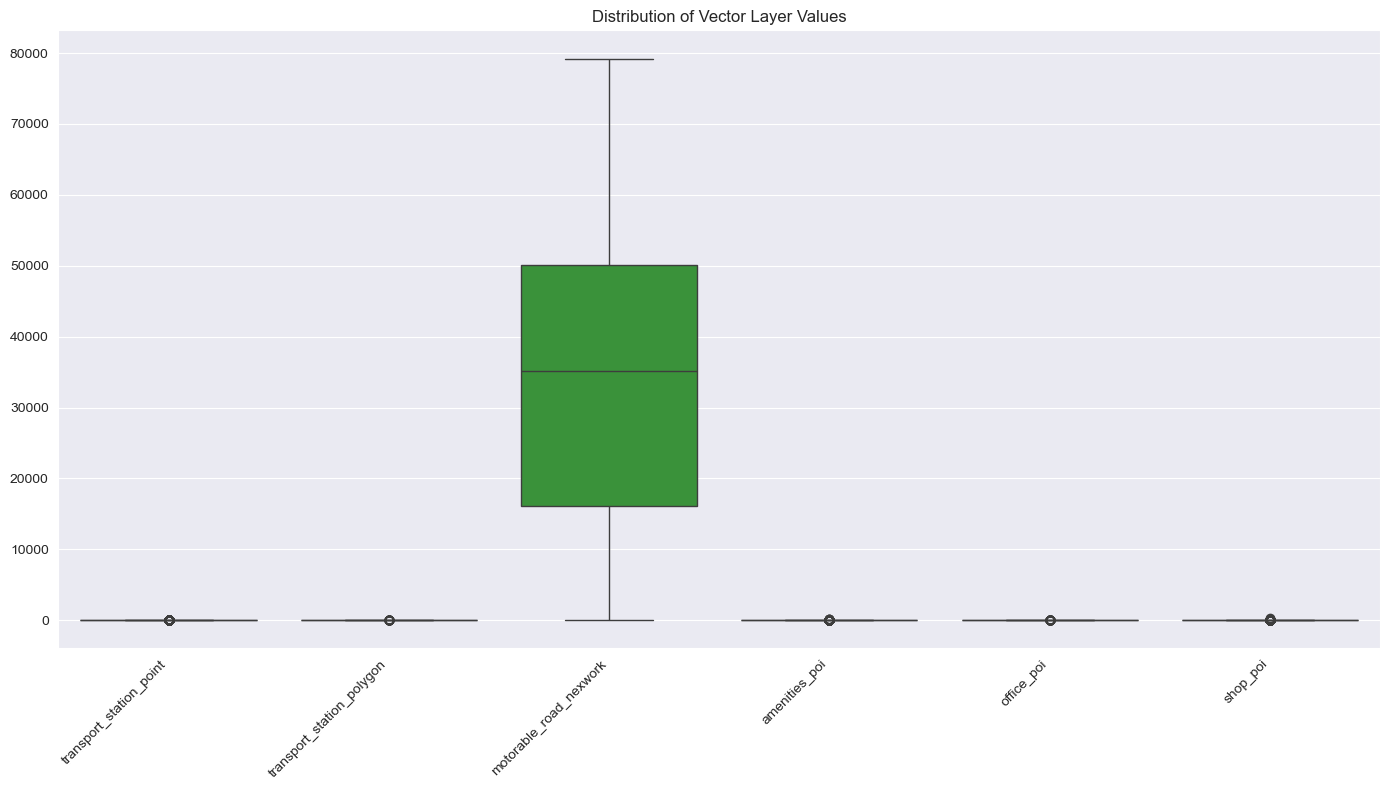

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only the vector layer columns
vector_cols = ['transport_station_point', 'transport_station_polygon',
               'motorable_road_nexwork', 'amenities_poi',
               'office_poi', 'shop_poi']

# Filter to include only vector columns that exist in the dataframe
available_vector_cols = [col for col in vector_cols if col in hexes.columns]

# Create the box plot
plt.figure(figsize=(14, 8))
sns.boxplot(data=hexes[available_vector_cols])

# Improve readability
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Vector Layer Values')
plt.tight_layout()
plt.show()

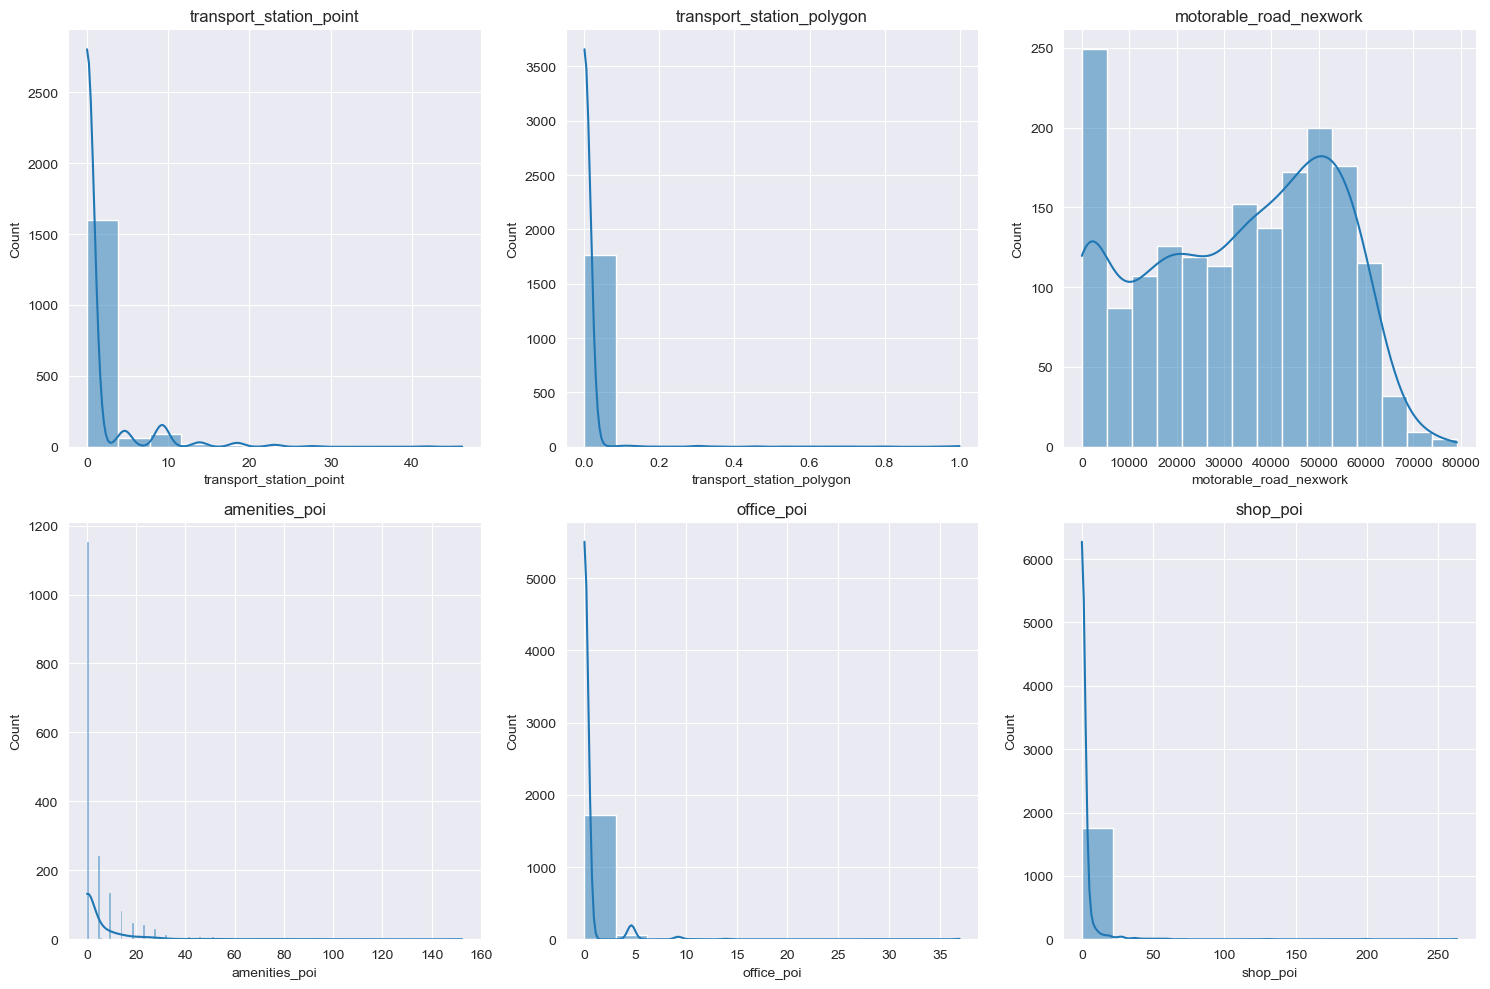

In [13]:
# Create a grid of histograms
plt.figure(figsize=(15, 10))
for i, col in enumerate(available_vector_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(hexes[col], kde=True)
    plt.title(f'{col}')
    plt.tight_layout()
plt.show()

In [14]:
cols_keep = [
    "hex_id",          # join key
    "geometry",        # hex polygon (CRS stays EPSG:32643 in GeoParquet metadata)
    "cover",           # coverage ratio (0–1)
    "transport_station_point",
    "transport_station_polygon",
    "motorable_road_nexwork",
    "amenities_poi",
    "office_poi",
    "shop_poi",
]

hex_vec_final = hexes[cols_keep].copy()

In [15]:
vec_vars = cols_keep[3:]                   # slice all indicator columns
hex_vec_final[vec_vars] = hex_vec_final[vec_vars].fillna(0)

In [16]:
out_parquet = "data/cleaned/pca/jaipur_hex_vectors.parquet"
hex_vec_final.to_parquet(out_parquet, index=False)
print("✓  Vector layer saved to", out_parquet)

✓  Vector layer saved to data/cleaned/pca/jaipur_hex_vectors.parquet
